# Winner of the tournament
We add columns to tournamen_info_df that have:
- The winner of the tournament
- If the winner came from losers
- The ratings of players playing in the top 8

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime 

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split  # Correct import

import sqlite3
import sys
import time
import tqdm
from tqdm.auto import tqdm
import pickle
import joblib
import os

if os.path.exists('/workspace/data_2'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data_2/'
else:
    data_path = '../data/'


### Load Data


In [32]:
sets_df = pd.read_pickle(data_path + 'dataset_full.pkl')

sets_df.head(3)



,key_x,game,tournament_key,winner_id,loser_id,p1_id,p2_id,p1_score,p2_score,valid_score,...,p1/m1/m1_alt2_updates,p2/m1/m1_alt2_elo,p2/m1/m1_alt2_rd,p2/m1/m1_alt2_updates,p1/m1_alt3_elo,p1/m1_alt3_rd,p1/m1_alt3_updates,p2/m1_alt3_elo,p2/m1_alt3_rd,p2/m1_alt3_updates
719,,melee,httpsbeastsmashchallongecomb5msb,Däumling,Schlimmshady,Schlimmshady,Däumling,0,2,True,...,0.0,1500.0,350.0,0.0,1500.0,350.0,0.0,1500.0,350.0,0.0
773,,melee,httpsbeastsmashchallongecomb5msb,NamiNami,ProSmasherTim,ProSmasherTim,NamiNami,1,2,True,...,0.0,1500.0,350.0,0.0,1500.0,350.0,0.0,1500.0,350.0,0.0
772,,melee,httpsbeastsmashchallongecomb5msb,Gusti,Kuja,Gusti,Kuja,2,1,True,...,0.0,1500.0,350.0,0.0,1500.0,350.0,0.0,1500.0,350.0,0.0


In [33]:
for i, col in enumerate(sets_df.columns):
    print(i, col)

0 key_x
1 game
2 tournament_key
3 winner_id
4 loser_id
5 p1_id
6 p2_id
7 p1_score
8 p2_score
9 valid_score
10 best_of
11 location_names
12 bracket_name
13 bracket_order
14 set_order
15 game_data
16 top_8
17 top_8_location_names
18 valid_top_8_bracket
19 top_8_bracket_location_names
20 major
21 key_y
22 start
23 end
24 start_week
25 p1_characters
26 p2_characters
27 p1_consistent
28 p2_consistent
29 matchup_strings
30 end_week
31 players_have_history
32 (p1/p2)_sorted
33 (p1/p2)_was_sorted
34 results_sorted
35 results
36 matchup_1
37 matchup_2
38 matchup_3
39 matchup_4
40 matchup_5
41 matchup_6
42 matchup_7
43 matchup_8
44 matchup_9
45 matchup_10
46 winner
47 p1_default_elo
48 p2_default_elo
49 p1_default_rd
50 p2_default_rd
51 p1_default_updates
52 p2_default_updates
53 start_index
54 start_date
55 p1_fox_count
56 p1_falco_count
57 p1_marth_count
58 p1_sheik_count
59 p1_captainfalcon_count
60 p1_jigglypuff_count
61 p1_peach_count
62 p1_luigi_count
63 p1_samus_count
64 p1_ganondorf_coun

In [34]:
tournament_info_df = pd.read_pickle(data_path + 'top_8_tournament_previous_sets_and_results_df')
print(tournament_info_df.columns)
print(tournament_info_df.head().to_string())

Index(['game', 'key', 'cleaned_name', 'source', 'tournament_name',
       'tournament_event', 'season', 'rank', 'start', 'end', 'country',
       'state', 'city', 'entrants', 'placings', 'losses', 'bracket_types',
       'online', 'lat', 'lng', 'LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
       'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2',
       'LN_A_p1_non_top_8_sets', 'LN_A_p2_non_top_8_sets',
       'LN_B_p1_non_top_8_sets', 'LN_B_p2_non_top_8_sets',
       'WSF_A_p1_non_top_8_sets', 'WSF_A_p2_non_top_8_sets',
       'WSF_B_p1_non_top_8_sets', 'WSF_B_p2_non_top_8_sets'],
      dtype='object')
    game                                            key                               cleaned_name     source                               tournament_name tournament_event season rank               start                 end country state           city  entrants                                                                                                                                  

### Winner of the tournament

In [35]:
valid_sets = sets_df[sets_df['valid_top_8_bracket']==True]

# Identify tournaments with 'GFR'
GFR_tournament_keys = valid_sets.loc[(valid_sets['top_8_bracket_location_names'] == 'GFR'), 'tournament_key'].copy()

# Filter 'GF' tournaments that do not have a corresponding 'GFR'
GF_tournament_results_df = valid_sets.loc[
    (valid_sets['top_8_bracket_location_names'] == 'GF') & (~valid_sets['tournament_key'].isin(GFR_tournament_keys)),
    ['tournament_key', 'winner_id']
].copy()

GF_tournament_results_df['GFR'] = False

# Filter 'GFR' tournament results
GFR_tournament_results_df = valid_sets.loc[
    valid_sets['top_8_bracket_location_names'] == 'GFR',
    ['tournament_key', 'winner_id']
]
GFR_tournament_results_df['GFR'] = True

# Concatenate the results
tournament_results_df = pd.concat([GF_tournament_results_df, GFR_tournament_results_df], ignore_index=False)

winners_finals_players_df = valid_sets[(valid_sets['top_8_location_names']=='WF')][['tournament_key', 'p1_id', 'p2_id']]

# Create a mapping of tournament_key to all players in losers finals
winners_finals_players_df = (
    winners_finals_players_df
    .groupby('tournament_key')[['p1_id', 'p2_id']]
    .apply(lambda df: set(df.values.flatten()))
    .to_dict()
)

# Update 'from_WF' column based on whether the winner_id is in the losers finals players
tournament_results_df['from_WF'] = tournament_results_df.apply(
    lambda row: row['winner_id'] in winners_finals_players_df.get(row['tournament_key'], set()),
    axis=1
)

top_8_player_columns = ['key', 'LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
                        'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2']

# Perform the merge and retain the index of `tournament_results_df`
tournament_results_df = pd.merge(
    tournament_results_df,
    tournament_info_df[top_8_player_columns],
    how='left',
    left_on='tournament_key',
    right_on='key'
)

# Drop the 'key' column
tournament_results_df = tournament_results_df.drop(columns=['key'])

# Preserve the original index of `tournament_results_df`
tournament_results_df.index = tournament_results_df.index

# Update 'from_winners' column based on whether the winner_id is in the WSF player columns
tournament_results_df['from_winners_side'] = tournament_results_df.apply(
    lambda row: row['winner_id'] in [
        row['WSF_A_p1'], row['WSF_A_p2'], row['WSF_B_p1'], row['WSF_B_p2']
    ],
    axis=1
)

# View the results
tournament_results_df.head()


,tournament_key,winner_id,GFR,from_WF,LN_A_p1,LN_A_p2,LN_B_p1,LN_B_p2,WSF_A_p1,WSF_A_p2,WSF_B_p1,WSF_B_p2,from_winners_side
0,httpsbeastsmashchallongecomb5msb,4465,False,True,Prof,48789,12870,5956,19573,1000,4465,6189,True
1,httpsparagonchallongecomorlando_2015_melee_sin...,1004,False,True,16342,4465,1008,1013,1004,6189,1003,15990,True
2,sandstormmeleetop64,6189,False,True,4465,1024,1008,1017,1004,6189,1000,16342,True
3,httpsdl4-5challongecomdl45meleeprobracket,6189,False,True,Hack,Vdogg,4215,Thomas,6103,6189,4465,12870,True
4,gomlmelee16,1004,False,True,1038,4111,[L2] EMG | Sauc3,1037,1024,1004,1007,1022,True


In [36]:
print(f"The winner of the tournament came from winners side {tournament_results_df['from_winners_side'].sum() / tournament_results_df.shape[0]:.0%} of the time.")
print(f"The winner of the tournament came from winners finals {tournament_results_df['from_WF'].sum() / tournament_results_df.shape[0]:.0%} of the time.")
print(f"A grand finals reset happened {tournament_results_df['GFR'].sum() / tournament_results_df.shape[0]:.0%} of the time.")
print(f"Given that a grand final reset occured, the player coming from the winners finals won {tournament_results_df[tournament_results_df['GFR']==True]['from_WF'].sum() / tournament_results_df['GFR'].sum():.0%} of the time.")
tournament_results_df.head()

The winner of the tournament came from winners side 97% of the time.
The winner of the tournament came from winners finals 92% of the time.
A grand finals reset happened 31% of the time.
Given that a grand final reset occured, the player coming from the winners finals won 74% of the time.


,tournament_key,winner_id,GFR,from_WF,LN_A_p1,LN_A_p2,LN_B_p1,LN_B_p2,WSF_A_p1,WSF_A_p2,WSF_B_p1,WSF_B_p2,from_winners_side
0,httpsbeastsmashchallongecomb5msb,4465,False,True,Prof,48789,12870,5956,19573,1000,4465,6189,True
1,httpsparagonchallongecomorlando_2015_melee_sin...,1004,False,True,16342,4465,1008,1013,1004,6189,1003,15990,True
2,sandstormmeleetop64,6189,False,True,4465,1024,1008,1017,1004,6189,1000,16342,True
3,httpsdl4-5challongecomdl45meleeprobracket,6189,False,True,Hack,Vdogg,4215,Thomas,6103,6189,4465,12870,True
4,gomlmelee16,1004,False,True,1038,4111,[L2] EMG | Sauc3,1037,1024,1004,1007,1022,True


In [37]:
top_8_player_columns = ['LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
                        'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2']


In [38]:
# Define the top 8 player columns and their corresponding bracket locations
top_8_player_columns = ['LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
                        'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2']
bracket_locations = ['LN_A', 'LN_B', 'WSF_A', 'WSF_B']

# Prepare a copy of tournament_results_df
result_df = tournament_results_df.copy()

# Iterate through the top 8 player columns and merge the corresponding ELO data
for bracket_location in bracket_locations:
    # Filter valid sets for the current bracket location
    relevant_sets = valid_sets[valid_sets['top_8_bracket_location_names'] == bracket_location][
        ['tournament_key', 'p1_default_elo', 'p2_default_elo']
    ]
    
    # Rename columns to ensure uniqueness
    relevant_sets.rename(columns={
        'p1_default_elo': f'{bracket_location}_p1_elo',
        'p2_default_elo': f'{bracket_location}_p2_elo'
    }, inplace=True)
    
    # Merge the ELO data with the result_df
    result_df = pd.merge(
        result_df,
        relevant_sets,
        on='tournament_key',
        how='left'
    )
    
result_df = result_df.loc[:, ~result_df.columns.duplicated()]


# Check for and drop duplicate columns


# View the resulting DataFrame
print(result_df.head().to_string())


                                       tournament_key winner_id    GFR  from_WF LN_A_p1 LN_A_p2           LN_B_p1 LN_B_p2 WSF_A_p1 WSF_A_p2 WSF_B_p1 WSF_B_p2  from_winners_side  LN_A_p1_elo  LN_A_p2_elo  LN_B_p1_elo  LN_B_p2_elo  WSF_A_p1_elo  WSF_A_p2_elo  WSF_B_p1_elo  WSF_B_p2_elo
0                    httpsbeastsmashchallongecomb5msb      4465  False     True    Prof   48789             12870    5956    19573     1000     4465     6189               True  1500.000000  1500.000000  1500.000000  1500.000000   1500.000000   1500.000000   1500.000000   1500.000000
1  httpsparagonchallongecomorlando_2015_melee_singles      1004  False     True   16342    4465              1008    1013     1004     6189     1003    15990               True  1500.000000  1895.135835  1500.000000  1500.000000   1500.000000   1731.836698   1500.000000   1500.000000
2                                 sandstormmeleetop64      6189  False     True    4465    1024              1008    1017     1004     6189     1

Calculate the Rank of the Winner

In [39]:
# Define player and ELO columns
player_cols = ['LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
               'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2']
elo_cols = ['LN_A_p1_elo', 'LN_A_p2_elo', 'LN_B_p1_elo', 'LN_B_p2_elo',
            'WSF_A_p1_elo', 'WSF_A_p2_elo', 'WSF_B_p1_elo', 'WSF_B_p2_elo']

# Make a copy to avoid modifying the original DataFrame
processed_df = result_df.copy()

# Ensure ELO columns are numeric
for col in elo_cols:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')

# Convert to numpy arrays
elos = processed_df[elo_cols].to_numpy()
players = processed_df[player_cols].to_numpy()
winners = processed_df['winner_id'].to_numpy()

# Rank ELOs in descending order (higher ELO gets rank 1)
sorted_indices = np.argsort(-elos, axis=1)

# Create a mask to find the winner's position
winner_positions = np.array([np.where(players[i] == winners[i])[0][0] for i in range(len(winners))])

# Get the winner's rank based on ELO
winner_ranks = np.array([
    np.where(sorted_indices[i] == winner_positions[i])[0][0] + 1  # Adding 1 for 1-based ranking
    for i in range(len(winners))
])

# Add the winner's rank to the DataFrame
processed_df['elo_rank_of_winner'] = winner_ranks

# Display the distribution of winner ranks
rank_counts = processed_df['elo_rank_of_winner'].value_counts().sort_index()
print(rank_counts)


elo_rank_of_winner
1    19446
2     5723
3     2346
4     1233
5      664
6      436
7      324
8      271
Name: count, dtype: int64


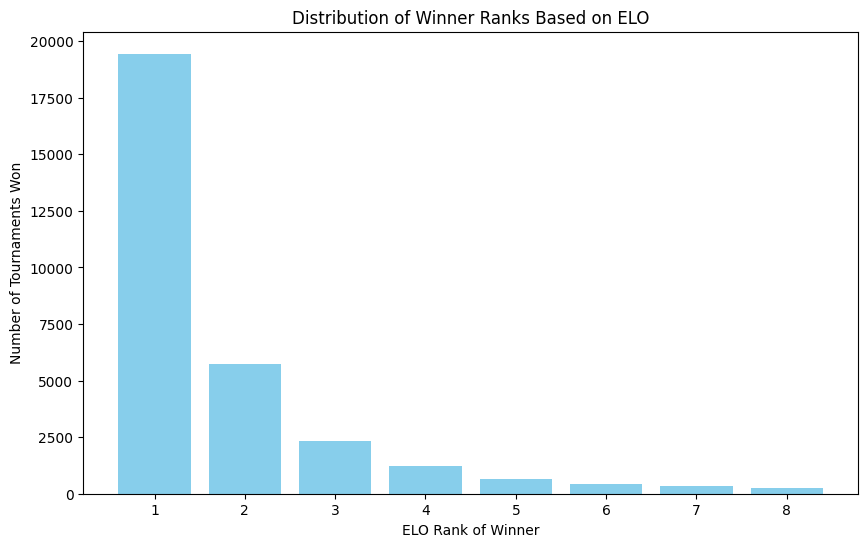

In [40]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(rank_counts.index, rank_counts.values, color='skyblue')
plt.xlabel('ELO Rank of Winner')
plt.ylabel('Number of Tournaments Won')
plt.title('Distribution of Winner Ranks Based on ELO')
plt.xticks(rank_counts.index)
plt.show()


Determine Winner's Side Participation

In [41]:
# Identify players from the winners' side
winners_side_cols = ['WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2']
winners_side_elos_cols = ['WSF_A_p1_elo', 'WSF_A_p2_elo', 'WSF_B_p1_elo', 'WSF_B_p2_elo']

# Get the top ELO among winners' side players
processed_df['top_winners_elo'] = processed_df[winners_side_elos_cols].max(axis=1)

# Get the corresponding player with the top ELO in winners' side
def get_top_winners_player(row):
    max_elo = row['top_winners_elo']
    for col in winners_side_elos_cols:
        if row[col] == max_elo:
            # Get the player column name
            player_col = col.replace('_elo', '')
            return row[player_col]
    return None

processed_df['top_winners_player'] = processed_df.apply(get_top_winners_player, axis=1)

# Check if the top-ranked player from the winners' side is the winner of the tournament
processed_df['top_winners_player_is_winner'] = processed_df['top_winners_player'] == processed_df['winner_id']

# Calculate how often the top-ranked player from the winners' side wins the tournament
top_winner_wins = processed_df['top_winners_player_is_winner'].value_counts()
print(top_winner_wins)


top_winners_player_is_winner
True     20181
False    10262
Name: count, dtype: int64


Plot the Probability of Top Winners' Side Player Winning

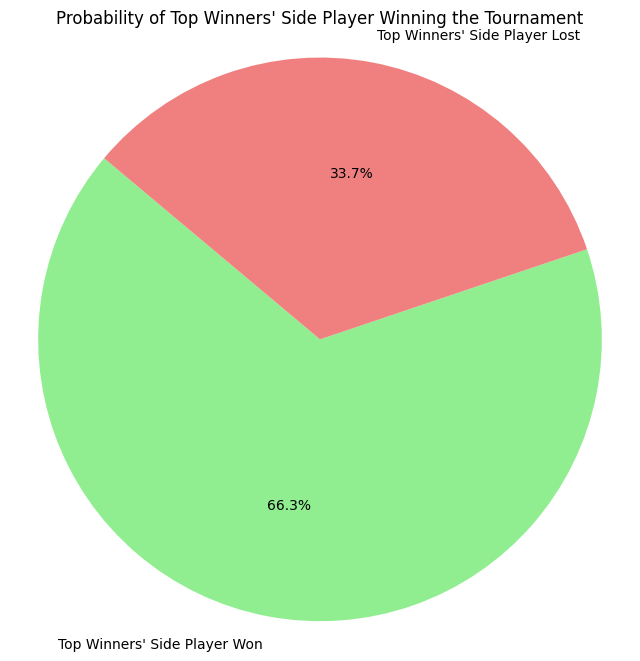

In [42]:
# Plotting the results
labels = ['Top Winners\' Side Player Won', 'Top Winners\' Side Player Lost']
sizes = [top_winner_wins[True], top_winner_wins[False]]
colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Probability of Top Winners\' Side Player Winning the Tournament')
plt.axis('equal')
plt.show()


Calculate Winner's Rank Among Winners' Side Players

In [43]:
# Get ELOs and players from winners' side
winners_elos = processed_df[winners_side_elos_cols].to_numpy()
winners_players = processed_df[winners_side_cols].to_numpy()

# Rank ELOs in descending order among winners' side players
sorted_winners_indices = np.argsort(-winners_elos, axis=1)

# Create a list to find the winner's position among winners' side players
winner_positions_winners_side = [
    np.where(winners_players[i] == winners[i])[0]
    for i in range(len(winners))
]

# Handle cases where the winner is not in the winners' side (e.g., came from losers)
winner_ranks_winners_side = []
for i in range(len(winners)):
    if winner_positions_winners_side[i].size > 0:
        position = winner_positions_winners_side[i][0]
        rank = np.where(sorted_winners_indices[i] == position)[0][0] + 1  # Adding 1 for 1-based ranking
        winner_ranks_winners_side.append(rank)
    else:
        winner_ranks_winners_side.append(None)  # Winner came from losers' side

# Add to the DataFrame
processed_df['elo_rank_of_winner_in_winners_side'] = winner_ranks_winners_side

# Display the distribution
winners_side_rank_counts = processed_df['elo_rank_of_winner_in_winners_side'].value_counts(dropna=False).sort_index()
print(winners_side_rank_counts)



elo_rank_of_winner_in_winners_side
1.0    20181
2.0     5919
3.0     2299
4.0     1155
NaN      889
Name: count, dtype: int64


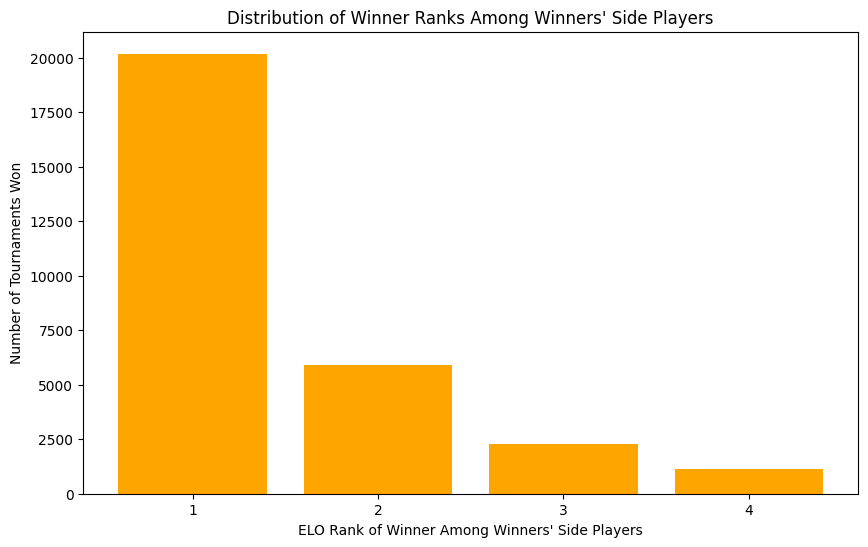

In [ ]:
# Remove NaN values for plotting
valid_ranks = processed_df['elo_rank_of_winner_in_winners_side'].dropna().astype(int)
rank_counts_ws = valid_ranks.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(rank_counts_ws.index, rank_counts_ws.values, color='orange')
plt.xlabel('ELO Rank of Winner Among Winners\' Side Players')
plt.ylabel('Number of Tournaments Won')
plt.title('Distribution of Winner Ranks Among Winners\' Side Players')
plt.xticks(rank_counts_ws.index)
plt.show()


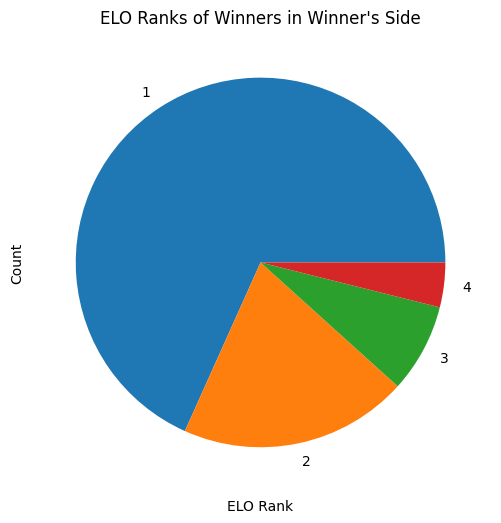

In [68]:
rank_counts_ws = valid_ranks.value_counts().sort_index()
x= rank_counts_ws/ valid_ranks.shape[0]
plt.figure(figsize=(10, 6))
plt.pie(x, labels=rank_counts_ws.index)
plt.xlabel("ELO Rank")
plt.ylabel("Count")
plt.title("ELO Ranks of Winners in Winner's Side")
plt.show()


In [45]:
# Baseline 1: Predict top-ranked player overall will win
processed_df['top_overall_elo'] = processed_df[elo_cols].max(axis=1)

def get_top_overall_player(row):
    max_elo = row['top_overall_elo']
    for col in elo_cols:
        if row[col] == max_elo:
            player_col = col.replace('_elo', '')
            return row[player_col]
    return None

processed_df['top_overall_player'] = processed_df.apply(get_top_overall_player, axis=1)
processed_df['top_overall_player_is_winner'] = processed_df['top_overall_player'] == processed_df['winner_id']

# Baseline 2: Predict top-ranked player from winners' side will win (already computed)
processed_df['top_winners_player_is_winner'] = processed_df['top_winners_player'] == processed_df['winner_id']

# Baseline 3: Predict the player from winners' finals with higher ELO will win
winners_finals_cols = ['WSF_A_p1', 'WSF_A_p2']
winners_finals_elos_cols = ['WSF_A_p1_elo', 'WSF_A_p2_elo']

processed_df['top_winners_finals_elo'] = processed_df[winners_finals_elos_cols].max(axis=1)

def get_top_winners_finals_player(row):
    max_elo = row['top_winners_finals_elo']
    for col in winners_finals_elos_cols:
        if row[col] == max_elo:
            player_col = col.replace('_elo', '')
            return row[player_col]
    return None

processed_df['top_winners_finals_player'] = processed_df.apply(get_top_winners_finals_player, axis=1)
processed_df['top_winners_finals_player_is_winner'] = processed_df['top_winners_finals_player'] == processed_df['winner_id']

# Calculate accuracies
baseline1_accuracy = processed_df['top_overall_player_is_winner'].mean()
baseline2_accuracy = processed_df['top_winners_player_is_winner'].mean()
baseline3_accuracy = processed_df['top_winners_finals_player_is_winner'].mean()

print(f"Baseline 1 Accuracy (Top Overall Player): {baseline1_accuracy:.2%}")
print(f"Baseline 2 Accuracy (Top Winners' Side Player): {baseline2_accuracy:.2%}")
print(f"Baseline 3 Accuracy (Top Winners' Finals Player): {baseline3_accuracy:.2%}")


Baseline 1 Accuracy (Top Overall Player): 63.88%
Baseline 2 Accuracy (Top Winners' Side Player): 66.29%
Baseline 3 Accuracy (Top Winners' Finals Player): 62.50%


In [46]:
# Ensure 'start' is datetime in tournament_info_df
tournament_info_df['start'] = pd.to_datetime(tournament_info_df['start'], errors='coerce')

# Merge 'result_df' with 'tournament_info_df' to get the 'start' date
processed_df = result_df.copy()

# Rename 'tournament_key' to 'key' in processed_df if necessary
if 'tournament_key' in processed_df.columns:
    processed_df = processed_df.rename(columns={'tournament_key': 'key'})

# Merge on 'key' to get 'start' date
processed_df = processed_df.merge(tournament_info_df[['key', 'start']], on='key', how='left')

# Extract the year
processed_df['year'] = processed_df['start'].dt.year

# Display the first few rows
processed_df.head()


,key,winner_id,GFR,from_WF,LN_A_p1,LN_A_p2,LN_B_p1,LN_B_p2,WSF_A_p1,WSF_A_p2,...,LN_A_p1_elo,LN_A_p2_elo,LN_B_p1_elo,LN_B_p2_elo,WSF_A_p1_elo,WSF_A_p2_elo,WSF_B_p1_elo,WSF_B_p2_elo,start,year
0,httpsbeastsmashchallongecomb5msb,4465,False,True,Prof,48789,12870,5956,19573,1000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,2015-01-11 14:16:13,2015
1,httpsparagonchallongecomorlando_2015_melee_sin...,1004,False,True,16342,4465,1008,1013,1004,6189,...,1500.000000,1895.135835,1500.000000,1500.000000,1500.000000,1731.836698,1500.000000,1500.000000,2015-01-18 22:45:13,2015
2,sandstormmeleetop64,6189,False,True,4465,1024,1008,1017,1004,6189,...,1875.401133,1780.859237,1802.371728,1557.258332,1880.172284,1940.202404,1887.356092,1659.186420,2015-04-19 22:15:03,2015
3,httpsdl4-5challongecomdl45meleeprobracket,6189,False,True,Hack,Vdogg,4215,Thomas,6103,6189,...,1500.000000,1500.000000,1669.123922,1572.129450,1500.000000,1983.490955,1865.556343,1626.664862,2015-05-02 23:55:20,2015
4,gomlmelee16,1004,False,True,1038,4111,[L2] EMG | Sauc3,1037,1024,1004,...,1563.128163,1500.000000,1500.000000,1442.201240,1797.494819,1890.609000,1625.112054,1790.698427,2015-05-31 08:26:30,2015


In [47]:
# Define player and ELO columns
player_cols = ['LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
               'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2']
elo_cols = ['LN_A_p1_elo', 'LN_A_p2_elo', 'LN_B_p1_elo', 'LN_B_p2_elo',
            'WSF_A_p1_elo', 'WSF_A_p2_elo', 'WSF_B_p1_elo', 'WSF_B_p2_elo']

# Ensure ELO columns are numeric
for col in elo_cols:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')

# Convert to numpy arrays
elos = processed_df[elo_cols].to_numpy()
players = processed_df[player_cols].to_numpy()
winners = processed_df['winner_id'].to_numpy()

# Rank ELOs in descending order (higher ELO gets rank 1)
sorted_indices = np.argsort(-elos, axis=1)

# Create a mask to find the winner's position
winner_positions = np.array([np.where(players[i] == winners[i])[0][0] for i in range(len(winners))])

# Get the winner's rank based on ELO
winner_ranks = np.array([
    np.where(sorted_indices[i] == winner_positions[i])[0][0] + 1  # Adding 1 for 1-based ranking
    for i in range(len(winners))
])

# Add the winner's rank to the DataFrame
processed_df['elo_rank_of_winner'] = winner_ranks

# Display the distribution of winner ranks
rank_counts = processed_df['elo_rank_of_winner'].value_counts().sort_index()
print(rank_counts)


elo_rank_of_winner
1    19446
2     5723
3     2346
4     1233
5      664
6      436
7      324
8      271
Name: count, dtype: int64


In [48]:
# Baseline 1: Predict top-ranked player overall will win
processed_df['top_overall_elo'] = processed_df[elo_cols].max(axis=1)

def get_top_overall_player(row):
    max_elo = row['top_overall_elo']
    for col in elo_cols:
        if row[col] == max_elo:
            player_col = col.replace('_elo', '')
            return row[player_col]
    return None

processed_df['top_overall_player'] = processed_df.apply(get_top_overall_player, axis=1)
processed_df['top_overall_player_is_winner'] = processed_df['top_overall_player'] == processed_df['winner_id']

# Baseline 2: Predict top-ranked player from winners' side will win
winners_side_cols = ['WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2']
winners_side_elos_cols = ['WSF_A_p1_elo', 'WSF_A_p2_elo', 'WSF_B_p1_elo', 'WSF_B_p2_elo']

processed_df['top_winners_elo'] = processed_df[winners_side_elos_cols].max(axis=1)

def get_top_winners_player(row):
    max_elo = row['top_winners_elo']
    for col in winners_side_elos_cols:
        if row[col] == max_elo:
            player_col = col.replace('_elo', '')
            return row[player_col]
    return None

processed_df['top_winners_player'] = processed_df.apply(get_top_winners_player, axis=1)
processed_df['top_winners_player_is_winner'] = processed_df['top_winners_player'] == processed_df['winner_id']

# Baseline 3: Predict the player from winners' finals with higher ELO will win
winners_finals_cols = ['WSF_A_p1', 'WSF_A_p2']
winners_finals_elos_cols = ['WSF_A_p1_elo', 'WSF_A_p2_elo']

processed_df['top_winners_finals_elo'] = processed_df[winners_finals_elos_cols].max(axis=1)

def get_top_winners_finals_player(row):
    max_elo = row['top_winners_finals_elo']
    for col in winners_finals_elos_cols:
        if row[col] == max_elo:
            player_col = col.replace('_elo', '')
            return row[player_col]
    return None

processed_df['top_winners_finals_player'] = processed_df.apply(get_top_winners_finals_player, axis=1)
processed_df['top_winners_finals_player_is_winner'] = processed_df['top_winners_finals_player'] == processed_df['winner_id']


In [49]:
# Initialize lists to store results
years = list(range(2015, 2025))  # 2015 to 2024 inclusive
baseline1_accuracies = []
baseline2_accuracies = []
baseline3_accuracies = []

for year in years:
    # Filter the dataframe for the given year
    df_year = processed_df[processed_df['year'] == year]
    
    # If no data for the year, skip
    if df_year.empty:
        baseline1_accuracies.append(None)
        baseline2_accuracies.append(None)
        baseline3_accuracies.append(None)
        continue
    
    # Baseline 1 Accuracy
    baseline1_accuracy = df_year['top_overall_player_is_winner'].mean()
    
    # Baseline 2 Accuracy
    baseline2_accuracy = df_year['top_winners_player_is_winner'].mean()
    
    # Baseline 3 Accuracy
    baseline3_accuracy = df_year['top_winners_finals_player_is_winner'].mean()
    
    # Append accuracies
    baseline1_accuracies.append(baseline1_accuracy)
    baseline2_accuracies.append(baseline2_accuracy)
    baseline3_accuracies.append(baseline3_accuracy)

# Create a DataFrame to store the results
baselines_df = pd.DataFrame({
    'Year': years,
    'Baseline 1 Accuracy': baseline1_accuracies,
    'Baseline 2 Accuracy': baseline2_accuracies,
    'Baseline 3 Accuracy': baseline3_accuracies
})

# Display the results
print(baselines_df)


   Year  Baseline 1 Accuracy  Baseline 2 Accuracy  Baseline 3 Accuracy
0  2015             0.600000             0.600000             0.800000
1  2016             0.653846             0.653846             0.576923
2  2017             0.602564             0.602564             0.538462
3  2018             0.680000             0.680000             0.520000
4  2019             0.619048             0.650794             0.634921
5  2020             0.561628             0.580233             0.538372
6  2021             0.575113             0.602678             0.555621
7  2022             0.634705             0.659622             0.619021
8  2023             0.662703             0.684455             0.654582
9  2024             0.675398             0.701189             0.661697


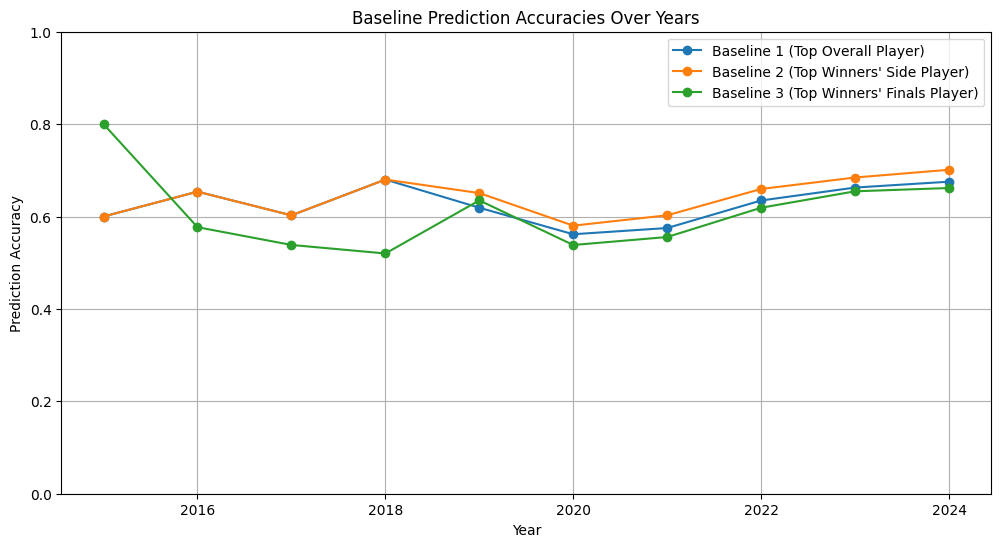

In [50]:
# Plotting
plt.figure(figsize=(12, 6))

plt.plot(baselines_df['Year'], baselines_df['Baseline 1 Accuracy'], marker='o', label='Baseline 1 (Top Overall Player)')
plt.plot(baselines_df['Year'], baselines_df['Baseline 2 Accuracy'], marker='o', label='Baseline 2 (Top Winners\' Side Player)')
plt.plot(baselines_df['Year'], baselines_df['Baseline 3 Accuracy'], marker='o', label='Baseline 3 (Top Winners\' Finals Player)')

plt.xlabel('Year')
plt.ylabel('Prediction Accuracy')
plt.title('Baseline Prediction Accuracies Over Years')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [51]:
processed_df.columns

Index(['key', 'winner_id', 'GFR', 'from_WF', 'LN_A_p1', 'LN_A_p2', 'LN_B_p1',
       'LN_B_p2', 'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2',
       'from_winners_side', 'LN_A_p1_elo', 'LN_A_p2_elo', 'LN_B_p1_elo',
       'LN_B_p2_elo', 'WSF_A_p1_elo', 'WSF_A_p2_elo', 'WSF_B_p1_elo',
       'WSF_B_p2_elo', 'start', 'year', 'elo_rank_of_winner',
       'top_overall_elo', 'top_overall_player', 'top_overall_player_is_winner',
       'top_winners_elo', 'top_winners_player', 'top_winners_player_is_winner',
       'top_winners_finals_elo', 'top_winners_finals_player',
       'top_winners_finals_player_is_winner'],
      dtype='object')

In [52]:
col_to_merge = ['key', 'winner_id', 'GFR', 'from_WF','from_winners_side', 'elo_rank_of_winner',
       'top_overall_elo', 'top_overall_player', 'top_overall_player_is_winner',
       'top_winners_elo', 'top_winners_player', 'top_winners_player_is_winner',
       'top_winners_finals_elo', 'top_winners_finals_player',
       'top_winners_finals_player_is_winner']


In [53]:
merged_df = pd.merge(tournament_info_df, processed_df[col_to_merge], how='left', left_on='key', right_on='key')

In [54]:
# Identify tournaments with 'GFR'
GFR_tournament_keys = sets_df.loc[(sets_df['top_8_location_names'] == 'GFR'), 'tournament_key'].copy()

# Filter 'GF' tournaments that do not have a corresponding 'GFR'
GF_tournament_results_df = sets_df.loc[
    (sets_df['top_8_location_names'] == 'GF') & (~sets_df['tournament_key'].isin(GFR_tournament_keys)),
    ['winner_id', 'p1_id', 'p2_id', 'p1_default_elo', 'p2_default_elo', 'tournament_key']
]

# Filter 'GFR' tournament results
GFR_tournament_results_df = sets_df.loc[
    sets_df['top_8_bracket_location_names'] == 'GFR',
    ['winner_id', 'p1_id', 'p2_id', 'p1_default_elo', 'p2_default_elo', 'tournament_key']
]

last_set = pd.concat([GF_tournament_results_df, GFR_tournament_results_df]).copy()

last_set['winner_default_elo'] = last_set['p1_default_elo']
last_set.loc[last_set['winner_id']==last_set['p2_id'],'winner_default_elo'] = last_set['p2_default_elo']
last_set = last_set.rename(columns={'tournament_key': 'key'})
print(last_set.columns)
print(tournament_info_df.columns)
merged_2_df = pd.merge(
    merged_df, 
    last_set[['key', 'winner_default_elo']],  # Use double square brackets to select multiple columns
    how='left', 
    left_on='key', 
    right_on='key'
)



Index(['winner_id', 'p1_id', 'p2_id', 'p1_default_elo', 'p2_default_elo',
       'key', 'winner_default_elo'],
      dtype='object')
Index(['game', 'key', 'cleaned_name', 'source', 'tournament_name',
       'tournament_event', 'season', 'rank', 'start', 'end', 'country',
       'state', 'city', 'entrants', 'placings', 'losses', 'bracket_types',
       'online', 'lat', 'lng', 'LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
       'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2',
       'LN_A_p1_non_top_8_sets', 'LN_A_p2_non_top_8_sets',
       'LN_B_p1_non_top_8_sets', 'LN_B_p2_non_top_8_sets',
       'WSF_A_p1_non_top_8_sets', 'WSF_A_p2_non_top_8_sets',
       'WSF_B_p1_non_top_8_sets', 'WSF_B_p2_non_top_8_sets'],
      dtype='object')


In [55]:
merged_2_df.columns

Index(['game', 'key', 'cleaned_name', 'source', 'tournament_name',
       'tournament_event', 'season', 'rank', 'start', 'end', 'country',
       'state', 'city', 'entrants', 'placings', 'losses', 'bracket_types',
       'online', 'lat', 'lng', 'LN_A_p1', 'LN_A_p2', 'LN_B_p1', 'LN_B_p2',
       'WSF_A_p1', 'WSF_A_p2', 'WSF_B_p1', 'WSF_B_p2',
       'LN_A_p1_non_top_8_sets', 'LN_A_p2_non_top_8_sets',
       'LN_B_p1_non_top_8_sets', 'LN_B_p2_non_top_8_sets',
       'WSF_A_p1_non_top_8_sets', 'WSF_A_p2_non_top_8_sets',
       'WSF_B_p1_non_top_8_sets', 'WSF_B_p2_non_top_8_sets', 'winner_id',
       'GFR', 'from_WF', 'from_winners_side', 'elo_rank_of_winner',
       'top_overall_elo', 'top_overall_player', 'top_overall_player_is_winner',
       'top_winners_elo', 'top_winners_player', 'top_winners_player_is_winner',
       'top_winners_finals_elo', 'top_winners_finals_player',
       'top_winners_finals_player_is_winner', 'winner_default_elo'],
      dtype='object')

In [ ]:
merged_2_df.to_pickle(data_path + 'top_8_tournament_previous_sets_and_results_with_winners_df')